# **ML-Based Intrusion Detection System (IDS)**

In [100]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy as np
import zipfile
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
# import scikitplot as skplt
import shap

In [101]:
def extract(file):
    """
    Function that extracts a compressed file and deletes it
    """
    # Extract the contents of the zip file
    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall()

    # Delete the zip file after extracting its contents
    os.remove(file)

In [102]:
# Function to plot performance metrics by epochs for a neural network
# param history - training history returned by the model
# param metric - evaluation metric
# param title - name of the image that is stored

def plot_history_metrics(history, metric, title):

  acc = history.history[metric]
  val_acc = history.history['val_'+str(metric)]

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1, 2, figsize=(16, 6))
  fig.suptitle('Metrics per epoch')
  color1 = "#4072c4"
  ax[0].plot(epochs, acc, label='Training')
  ax[0].plot(epochs, val_acc, label='Validation')
  ax[0].set_title(f'Training and validation {metric}')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel(metric)
  ax[0].legend()

  ax[1].plot(epochs, loss, label='Training')
  ax[1].plot(epochs, val_loss, label='Validation')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')
  ax[1].legend()
  plt.savefig(f'Metrics_per_epoch_{title}.png')
  plt.show()


In [103]:


def classification_metrics(y_test, y_pred):

  accuracy = metrics.accuracy_score(y_test, y_pred)
  print(f'Accuracy: {accuracy:.4f}')

  f1 = metrics.f1_score(y_test, y_pred, average='weighted')
  print(f'\nF1-Score: {f1:.4f}')

  recall = metrics.recall_score(y_test, y_pred, average='weighted')
  precision = metrics.precision_score(y_test, y_pred, average='weighted')
  print(f'\nRecall: {recall:.4f}')
  print(f'\nPrecision: {precision:.4f}')

  report = metrics.classification_report(y_test, y_pred)
  print(f'\nDetailed Report:\n\n {report}')

  print(f'\n#----------------------------End-----------------------------#\n')

In [104]:


def my_confusion_matrix(y_test, y_pred, labels, title):

  plabels = ["Pred. " + label for label in labels]

  cm = metrics.confusion_matrix(y_test, y_pred)
  df_cm = pd.DataFrame(cm, index=labels, columns=plabels)

  print('\n')
  plt.figure(figsize=(6,4))
  sns.heatmap(df_cm, annot=True, fmt='g', cmap=sns.diverging_palette(220, 20, as_cmap=True), linewidths=.5)

  plt.title('Confusion Matrix', fontsize=20)
  plt.ylabel('True Label', fontsize=15)
  plt.xlabel('Predicted Label', fontsize=15)
  plt.savefig(f'Confusion_matrix_{title}.png')
  plt.show()


In [105]:
def roc(y_test, y_pred, title):

  color1 = "#4072c4"

  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
  print(f'False Positive Rate:\n {fpr[:10]}\n')
  print(f'True Positive Rate:\n {tpr[:10]}\n')
  print(f'Threshold:\n {thresholds[:10]}\n')

  roc_auc = metrics.auc(fpr, tpr)

  print(f'AUC (Area Under the Curve): {roc_auc:.4f}\n')

  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color=color1, lw=2, label=f'AUC = {roc_auc:.2f}')
  plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend(loc='lower right')
  plt.savefig(f'ROC_{title}.png')
  plt.show()


The following code defines a function called `comparador` that compares the evaluation metrics of various classification models. The function takes three parameters:

- `y_test`: The test set labels.
- `predicciones`: A dictionary where the key is the model name and the value is the predicted probability.
- `title`: The name of the image that will be stored.

The function performs the following tasks:

1. Creates a DataFrame to store the evaluation metrics (Accuracy, F1-score, Recall, Precision, AUC-ROC) for each model.
2. Plots the ROC curves for each model and saves the plot as an image.
3. Prints a detailed classification report for each model, including precision, recall, and F1-score for each class.
4. Displays the DataFrame containing the evaluation metrics for all models.

The function uses the ROC curve and AUC to visualize the performance of each model and provides a comprehensive comparison of their evaluation metrics.


In [106]:
# Function that displays a comparison of evaluation metrics for various
# classification models
# param y_test - y test set
# param prediccion - dictionary key=model name, value=prediction probability
# param title - name of the image that is stored

def comparador(y_test, predicciones, title):

  df = pd.DataFrame({'Metric': ['Accuracy', 'F1-score', 'Recall', 'Precision','AUC-ROC']})

  # Create a subplot
  fig, ax = plt.subplots(1, len(predicciones), figsize=(18, 6))
  fig.suptitle('ROC Curve Comparison')
  color1 = "#4072c4"

  for modelo, y_pred in predicciones.items():
    y_pred_bin = tf.round(y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    df[modelo] = [
        f'{metrics.accuracy_score(y_test, y_pred_bin)*100:.2f}%',
        f"{metrics.f1_score(y_test, y_pred_bin, average='weighted')*100:.2f}%",
        f"{metrics.recall_score(y_test, y_pred_bin, average='weighted')*100:.2f}%",
        f"{metrics.precision_score(y_test, y_pred_bin, average='weighted')*100:.2f}%",
        f'{metrics.auc(fpr, tpr)*100:.2f}%'
    ]

    ax[list(predicciones.keys()).index(modelo)].set_title(modelo)
    ax[list(predicciones.keys()).index(modelo)].plot(fpr, tpr, color=color1, lw=2, label=f'AUC {df.at[4, modelo]}')
    ax[list(predicciones.keys()).index(modelo)].plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
    ax[list(predicciones.keys()).index(modelo)].set_xlabel("False Positive Rate")
    ax[list(predicciones.keys()).index(modelo)].set_ylabel("True Positive Rate")
    ax[list(predicciones.keys()).index(modelo)].legend()

    report_model = metrics.classification_report(y_test, y_pred_bin, output_dict=True)
    print(f"\nModel {modelo}:\n")
    print("{:<10} {:<10} {:<10} {:<10}".format('Class', 'Precision', 'Recall', 'F1-score'))
    for clase, metricas in report_model.items():
        if clase.isdigit(): 
            print("{:<10} {:<10.2f} {:<10.2f} {:<10.2f}".format(clase, metricas['precision'], metricas['recall'], metricas['f1-score']))

  print(f'\n{df}\n')
  plt.savefig(f'ROC_comparative_{title}.png')
  plt.show()



---

# Import of Dataset

---

Let's download the dataset first:

In [107]:
!gdown 1Ki4Qcb-xaNlCHWypLpzH-aNHFWPLVRm4

'gdown' is not recognized as an internal or external command,
operable program or batch file.


In [108]:
# Extract the contents of the ZIP file
# extract('df_ids_v1.zip')

df1 = pd.read_csv("df_ids_0_B_v1.csv")
df2 = pd.read_csv("df_ids_1_B_v1.csv")
df3 = pd.read_csv("df_ids_2_B_v1.csv")
df4 = pd.read_csv("df_ids_3_B_v1.csv")

# Create a single DataFrame with the curated data
df = pd.concat([df1, df2, df3, df4], axis=0)

# Verify that the DataFrame was created correctly
df.head()

,Flow_Duration,Bwd_Packet_Length_Mean,Bwd_Packet_Length_Std,Flow_IAT_Std,Fwd_IAT_Total,Fwd_IAT_Std,Packet_Length_Mean,Packet_Length_Std,Avg_Bwd_Segment_Size,Idle_Mean,Label
0,48,0.000,0.000000,3.252691e+01,48,3.252691e+01,30.75,21.685248,0.000,0.000,0
1,79699,0.000,0.000000,0.000000e+00,0,0.000000e+00,0.00,0.000000,0.000,0.000,0
2,216,86.000,0.000000,8.292768e+01,3,0.000000e+00,54.20,29.029296,86.000,0.000,0
3,61422080,422.375,553.067913,3.887308e+06,61400000,4.913270e+06,241.60,420.903943,422.375,9981019.833,0
4,47,0.000,0.000000,0.000000e+00,0,0.000000e+00,0.00,0.000000,0.000,0.000,0


We then plot the info of the DataFrame columns:

In [109]:
filtered_data = df[df['Label'] == 1]
filtered_data.head()

,Flow_Duration,Bwd_Packet_Length_Mean,Bwd_Packet_Length_Std,Flow_IAT_Std,Fwd_IAT_Total,Fwd_IAT_Std,Packet_Length_Mean,Packet_Length_Std,Avg_Bwd_Segment_Size,Idle_Mean,Label
112214,68704799,1932.5,2845.835677,2.070000e+07,68600000,3.070000e+07,918.923077,2082.606278,1932.5,68600000.0,1
112215,12829,0.0,0.000000,7.150366e+03,297,0.000000e+00,3.600000,3.286335,0.0,0.0,1
112216,71,6.0,0.000000,0.000000e+00,0,0.000000e+00,3.333333,2.309401,6.0,0.0,1
112217,602132,1934.5,2177.344966,2.125453e+05,699,4.886108e+02,1163.300000,1903.962654,1934.5,0.0,1
112218,71,6.0,0.000000,0.000000e+00,0,0.000000e+00,2.000000,3.464102,6.0,0.0,1


In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 851750 entries, 0 to 204635
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Flow_Duration           851750 non-null  int64  
 1   Bwd_Packet_Length_Mean  851750 non-null  float64
 2   Bwd_Packet_Length_Std   851750 non-null  float64
 3   Flow_IAT_Std            851750 non-null  float64
 4   Fwd_IAT_Total           851750 non-null  int64  
 5   Fwd_IAT_Std             851750 non-null  float64
 6   Packet_Length_Mean      851750 non-null  float64
 7   Packet_Length_Std       851750 non-null  float64
 8   Avg_Bwd_Segment_Size    851750 non-null  float64
 9   Idle_Mean               851750 non-null  float64
 10  Label                   851750 non-null  int64  
dtypes: float64(8), int64(3)
memory usage: 78.0 MB


We now display the amount of 'benign' and 'attack' registries in the DataFrame.

In [111]:
attack = (df['Label'] == 1).sum()
benign = (df['Label'] == 0).sum()

print("attacks:",   attack)
print("benigns:", benign)

attacks: 425875
benigns: 425875



---

# Model Implementation

---

In [165]:
X = df.drop(columns='Label')
y = df['Label']
train_ratio = 0.70

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=42, shuffle=True, stratify=y)



## **Model 1 (Random Forest)**

Creation and training of a Random Forest Algorithm:

In [113]:
Random_Forest = RandomForestClassifier(max_depth=40)
X_train_np = X_train.values
X_train = X_train_np.reshape(X_train.shape[0], -1)  # Flatten the 3D array into 2D
Random_Forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=40)

Let's then perform the cross-validation:

In [114]:
RF_cv_scores = cross_val_score(Random_Forest, X_train, y_train, cv=5)
print(f'   mean of scores: {RF_cv_scores.mean():.4f}\n')
print(f'   std of scores : {RF_cv_scores.std():.4f}\n')

   mean of scores: 0.9946

   std of scores : 0.0001



In [115]:
# safe_network_record = [
#     [50, 0.000, 0.000000, 32.526910, 50, 32.526910, 29.50, 20.123456, 0.000, 0.000],
#     [300, 200.000, 25.123456, 120.789012, 290, 100.567890, 500.75, 300.876543, 180.000, 90.123456]
# ]
# malicious_record = [
#     [6000, 3500.000, 570.000000, 2900.000000, 580, 150.000000, 600.00, 450.000000, 320.000, 150.000]
# ]
RF_y_pred = Random_Forest.predict(X_test)
RF_y_pred_prob = Random_Forest.predict_proba(X_test)[:,1]
# RF_y_pred


C:\Users\vasum\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\vasum\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [116]:
# y_test[:10]

2. **Representation of Metrics**

In [117]:
classification_metrics(y_test, RF_y_pred)

Accuracy: 0.9948

F1-Score: 0.9948

Recall: 0.9948

Precision: 0.9948

Detailed Report:

               precision    recall  f1-score   support

           0       0.99      1.00      0.99    127763
           1       1.00      0.99      0.99    127763

    accuracy                           0.99    255526
   macro avg       0.99      0.99      0.99    255526
weighted avg       0.99      0.99      0.99    255526


#----------------------------End-----------------------------#



### **Results**

The results are extraordinary, with nearly 100% accuracy in classifying benign packets and 99% accuracy in classifying malicious packets. In terms of correct predictions, the model achieves 99% accuracy for benign packets and almost 100% for attacks. We observe stability in the metric results, which adds robustness to the model's outcomes.



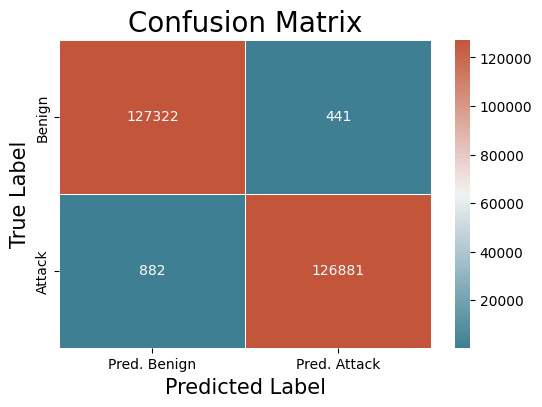

In [118]:
labels = ['Benign', 'Attack']
my_confusion_matrix(y_test, RF_y_pred, labels, 'RandomForest')

There is a slightly higher percentage of false negatives compared to false positives, although the priority is to reduce false negatives (actual attacks classified as benign). With the obtained metrics, this small imbalance can be overlooked.


False Positive Rate:
 [0.         0.00041483 0.00041483 0.00041483 0.00041483 0.00041483
 0.00041483 0.00042266 0.00042266 0.00043048]

True Positive Rate:
 [0.         0.90055806 0.90104334 0.90132511 0.9033523  0.90559865
 0.90789196 0.90789196 0.90790761 0.90940257]

Threshold:
 [       inf 1.         0.9999187  0.99978947 0.99851941 0.9984829
 0.9984259  0.99833333 0.998      0.99798954]

AUC (Area Under the Curve): 0.9989



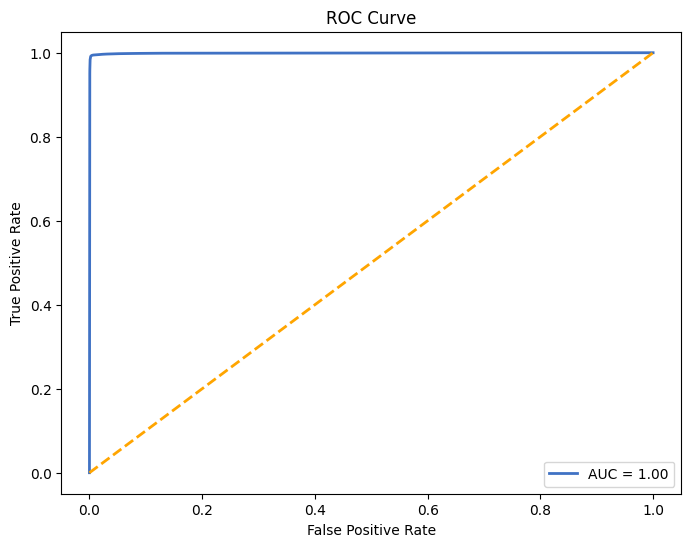

In [119]:
roc(y_test, RF_y_pred_prob, 'RandomForest')


We observe the ROC curve almost entirely in the upper left corner, indicating nearly perfect classification capability for different thresholds. The AUC confirms that the area under the curve is the maximum.

## **Model 2 (KNN):**



In [120]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [121]:
KNN_cv_scores = cross_val_score(knn, X_train, y_train, cv=5)
print(f'   Mean of scores: {KNN_cv_scores.mean():.4f}\n')
print(f'   Standard deviation: {KNN_cv_scores.std():.4f}\n')

   Mean of scores: 0.9879

   Standard deviation: 0.0004



We perform cross-validation to ensure that the model does not produce overfitting. As we can observe, the average accuracy of each subset is very high, and there is minimal variation in accuracy between subsets.


In [122]:
# Predictions
KNN_y_pred = knn.predict(X_test)
KNN_y_pred_prob = knn.predict_proba(X_test)[:,1]

C:\Users\vasum\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\Users\vasum\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(



### **Evaluation**

1. **Representation of Metrics**



In [123]:
classification_metrics(y_test, KNN_y_pred)

Accuracy: 0.9886

F1-Score: 0.9886

Recall: 0.9886

Precision: 0.9886

Detailed Report:

               precision    recall  f1-score   support

           0       0.99      0.99      0.99    127763
           1       0.99      0.99      0.99    127763

    accuracy                           0.99    255526
   macro avg       0.99      0.99      0.99    255526
weighted avg       0.99      0.99      0.99    255526


#----------------------------End-----------------------------#



The results are also very good, with 99% accuracy in all metrics, although it is slightly less precise than Random Forest.

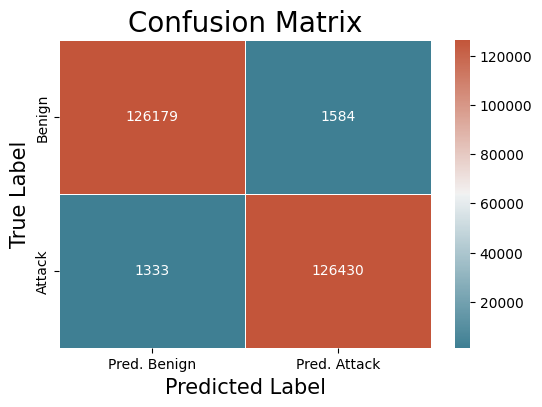

In [124]:
my_confusion_matrix(y_test, KNN_y_pred, labels, 'KNN')

In [125]:
print(y_test.shape)

(255526,)


False Positive Rate:
 [0.         0.00478229 0.00834357 0.01239796 0.02017799 0.04478605
 1.        ]

True Positive Rate:
 [0.         0.97392829 0.9861384  0.98956662 0.99215735 0.99515509
 1.        ]

Threshold:
 [inf 1.  0.8 0.6 0.4 0.2 0. ]

AUC (Area Under the Curve): 0.9949



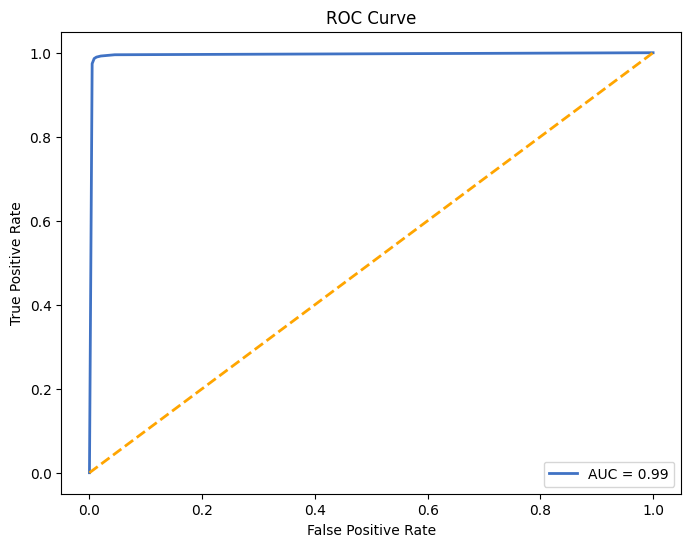

In [126]:
roc(y_test, KNN_y_pred_prob, 'KNN')

# **7. Model 3 "Experimental" (CNN):**

Let's start with the definition of the train, validation and test sets:

In [129]:
tf.random.set_seed(42)
X_CNN = np.expand_dims(X, axis=-1)

In [167]:
print(f'X_train shape: {X_train.shape}')
print(y_train.shape)

X_train shape: (596224, 10)
(596224,)


The below code defines a neural network model using Keras. It includes convolutional layers, batch normalization, a fully connected layer, and a dropout layer. The model is compiled with binary cross-entropy loss and the Adam optimizer. The code also includes a function to verify the input shape of the data.


In [168]:
# Define the neural network
model = Sequential()

# Input layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(10,1)))
#model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# Convolutional block 2
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# Fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(1, activation='sigmoid'))
# We use the sigmoid activation function since our model is binary.

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model.summary()

# Verify the input shape
def verify_input_shape(model, X):
    # Get the expected input shape from the model
    expected_input_shape = model.input_shape[1:]

    # Get the actual input shape of the data
    actual_input_shape = X.shape[1:]

    # Compare the expected and actual input shapes
    if expected_input_shape == actual_input_shape:
        print("Input shape is correct:", expected_input_shape)
    else:
        print("Input shape mismatch:", expected_input_shape, "vs", actual_input_shape)

# Verify the input shape
verify_input_shape(model, X_CNN)


C:\Users\vasum\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 8, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 6, 64)          │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 6, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,129 (219.25 KB)

 Trainable params: 55,937 (218.50 KB)

 Non-trainable params: 192 (768.00 B)

Input shape is correct: (10, 1)


In [172]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
18632/18632 ━━━━━━━━━━━━━━━━━━━━ 89s 5ms/step - accuracy: 0.7982 - loss: 0.4154
Epoch 2/10
18632/18632 ━━━━━━━━━━━━━━━━━━━━ 107s 6ms/step - accuracy: 0.8809 - loss: 0.2903
Epoch 3/10
18632/18632 ━━━━━━━━━━━━━━━━━━━━ 148s 8ms/step - accuracy: 0.9149 - loss: 0.2397
Epoch 4/10
18632/18632 ━━━━━━━━━━━━━━━━━━━━ 115s 6ms/step - accuracy: 0.9230 - loss: 0.2231
Epoch 5/10
18632/18632 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - accuracy: 0.9284 - loss: 0.2110
Epoch 6/10
18632/18632 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - accuracy: 0.9338 - loss: 0.1970
Epoch 7/10
18632/18632 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - accuracy: 0.9314 - loss: 0.2164
Epoch 8/10
18632/18632 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 0.9440 - loss: 0.1624
Epoch 9/10
18632/18632 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - accuracy: 0.9446 - loss: 0.1575
Epoch 10/10
18632/18632 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.9627 - loss: 0.1209


The accuracy of the training and validation sets is oscillating by epochs, indicating instability in capturing the complexity of the data. Nevertheless, the accuracy is good.


In [175]:
y_pred_prob3 = model.predict(X_test)
y_pred3 = tf.round(y_pred_prob3) 

7986/7986 ━━━━━━━━━━━━━━━━━━━━ 8s 929us/step


In [176]:
classification_metrics(y_test, y_pred3)

Accuracy: 0.9770

F1-Score: 0.9770

Recall: 0.9770

Precision: 0.9770

Detailed Report:

               precision    recall  f1-score   support

           0       0.97      0.98      0.98    127763
           1       0.98      0.97      0.98    127763

    accuracy                           0.98    255526
   macro avg       0.98      0.98      0.98    255526
weighted avg       0.98      0.98      0.98    255526


#----------------------------End-----------------------------#




We observe generally good metrics. If we look at the details by class, for benign cases, we have better recall than precision, and for attack cases, it is the opposite.


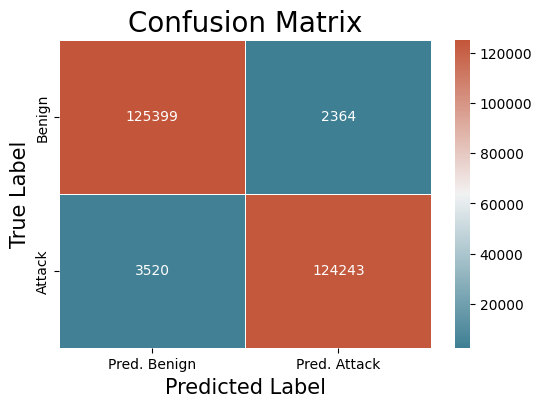

In [177]:
my_confusion_matrix(y_test, y_pred3, labels, 'CNN')


We confirm the number of actual benign cases predicted as attacks, as shown by the Recall metric.


False Positive Rate:
 [0.00000000e+00 1.56539843e-05 1.56539843e-05 1.56539843e-05
 1.56539843e-05 1.56539843e-05 1.56539843e-05 1.56539843e-05
 1.56539843e-05 1.56539843e-05]

True Positive Rate:
 [0.         0.09170104 0.09382216 0.09478488 0.09534842 0.09580238
 0.09621721 0.09649899 0.0968512  0.0971408 ]

Threshold:
 [       inf 1.         0.99999994 0.9999999  0.9999998  0.99999976
 0.9999997  0.99999964 0.9999996  0.9999995 ]

AUC (Area Under the Curve): 0.9950



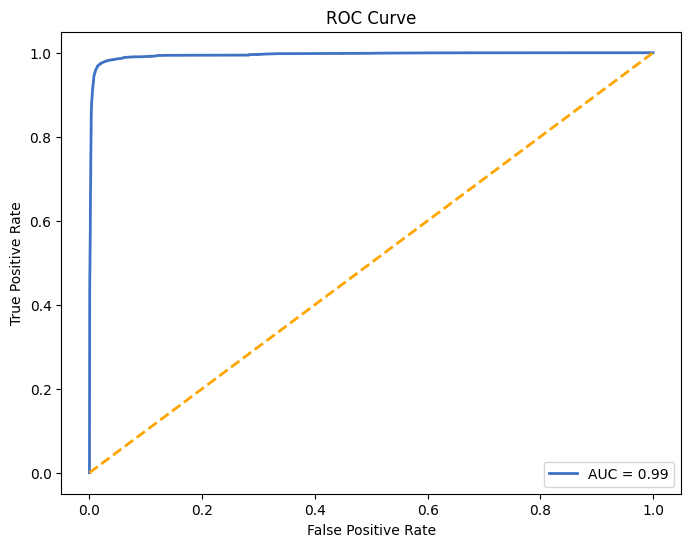

In [179]:
roc(y_test, y_pred_prob3, 'CNN')



## **Model 4 (xgboost):**



In [139]:
import xgboost as xgb

In [ ]:
print(X_train.shape)

X_train = X_train.reshape(-1, 10)

print(X_train.shape)

y_train = y_train.ravel()

print(y_train.shape)


(596224, 10)
(596224, 10)
(596224,)


In [ ]:
XGB = xgb.XGBClassifier(
    objective='binary:logistic', 
    eval_metric='logloss', 
    max_depth=4,  
    eta=0.1, 
    use_label_encoder=False  
)


XGB_cv_scores = cross_val_score(XGB,X_train, y_train, cv=5)

print(f'   Mean of scores: {XGB_cv_scores.mean():.4f}\n')
print(f'   Standard deviation: {XGB_cv_scores.std():.4f}\n')



C:\Users\vasum\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [19:24:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\vasum\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [19:24:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\vasum\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [19:24:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg,

   Mean of scores: 0.9860

   Standard deviation: 0.0003



In [ ]:
X_test = X_test.reshape(-1, 10)  # Reshape to have 10 features

xgb_y_predict = XGB.fit(X_train, y_train).predict(X_test)

xgb_y_predict_prob = XGB.predict_proba(X_test)[:, 1]




C:\Users\vasum\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [19:26:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


EVALUATION

In [195]:
classification_metrics(y_test, xgb_y_predict)

Accuracy: 0.9865

F1-Score: 0.9865

Recall: 0.9865

Precision: 0.9866

Detailed Report:

               precision    recall  f1-score   support

           0       0.98      0.99      0.99    127763
           1       0.99      0.98      0.99    127763

    accuracy                           0.99    255526
   macro avg       0.99      0.99      0.99    255526
weighted avg       0.99      0.99      0.99    255526


#----------------------------End-----------------------------#



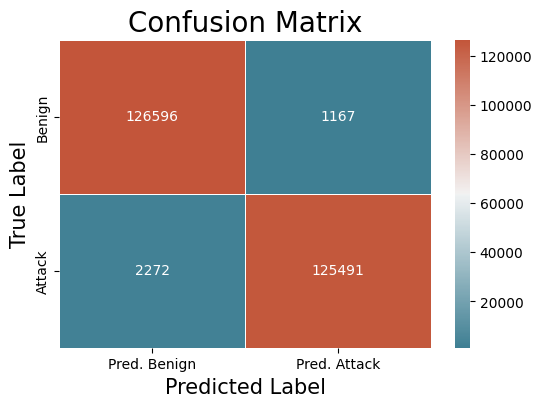

In [196]:
my_confusion_matrix(y_test, xgb_y_predict, labels, 'XGB')

False Positive Rate:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

True Positive Rate:
 [0.         0.00378044 0.0103238  0.01235882 0.0468602  0.15557712
 0.15581193 0.156759   0.15965499 0.15969412]

Threshold:
 [       inf 0.9997811  0.99977607 0.999775   0.9997745  0.9997689
 0.9997683  0.99976486 0.9997621  0.9997615 ]

AUC (Area Under the Curve): 0.9988



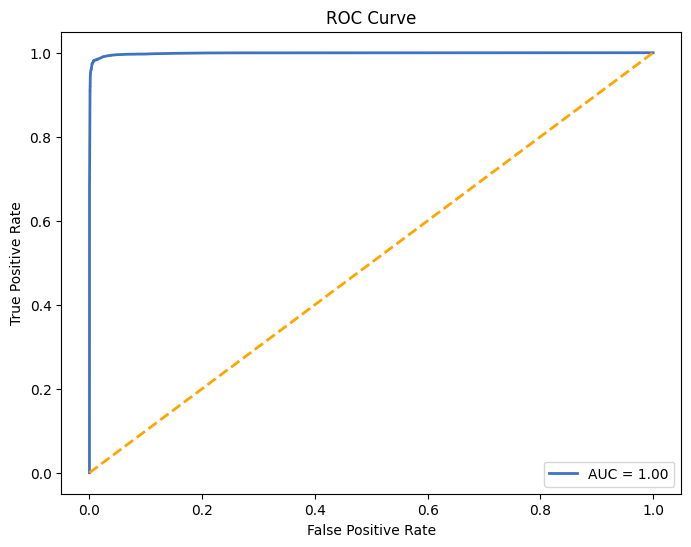

In [197]:
roc(y_test, xgb_y_predict_prob, 'XGB')




## **Model 5 (LogisticRegression):**



In [198]:
from sklearn.linear_model import LogisticRegression

In [199]:
logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [200]:
logistic_cv_scores=cross_val_score(logistic_regression, X_train, y_train, cv=5)
print(f'   Mean of scores: {logistic_cv_scores.mean():.4f}\n')
print(f'   Standard deviation: {logistic_cv_scores.std():.4f}\n')

   Mean of scores: 0.7707

   Standard deviation: 0.0014



In [201]:
logistic_y_predict=logistic_regression.predict(X_test.reshape(-1, 10))
logistic_y_predict_prob = logistic_regression.predict_proba(X_test.reshape(-1, 10))[:,1]

EVALUATION

In [202]:
classification_metrics(y_test, logistic_y_predict)

Accuracy: 0.7692

F1-Score: 0.7668

Recall: 0.7692

Precision: 0.7807

Detailed Report:

               precision    recall  f1-score   support

           0       0.72      0.87      0.79    127763
           1       0.84      0.67      0.74    127763

    accuracy                           0.77    255526
   macro avg       0.78      0.77      0.77    255526
weighted avg       0.78      0.77      0.77    255526


#----------------------------End-----------------------------#



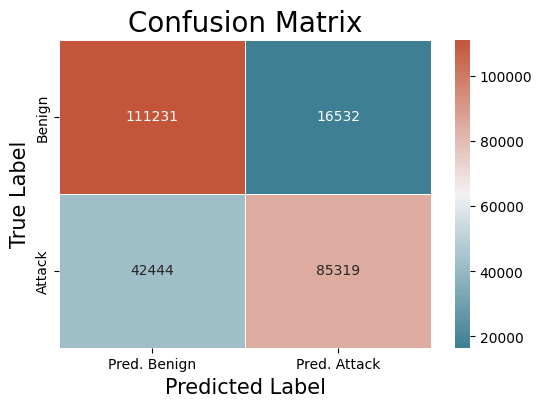

In [203]:
my_confusion_matrix(y_test, logistic_y_predict, labels, 'Logistic')

False Positive Rate:
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 7.82699217e-06
 7.82699217e-06 1.56539843e-05 1.56539843e-05 2.34809765e-05
 2.34809765e-05 3.13079687e-05]

True Positive Rate:
 [0.00000000e+00 7.82699217e-06 1.18398910e-01 1.18398910e-01
 1.29513239e-01 1.29513239e-01 1.30789039e-01 1.30789039e-01
 1.32370091e-01 1.32370091e-01]

Threshold:
 [       inf 1.         0.99994488 0.99994488 0.99989329 0.99989328
 0.99988504 0.99988496 0.99987121 0.99987106]

AUC (Area Under the Curve): 0.8684



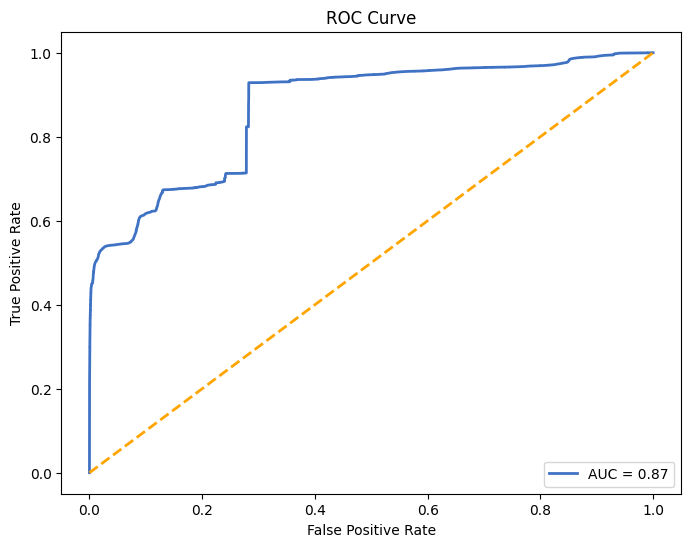

In [204]:
roc(y_test, logistic_y_predict_prob, 'Logistic')



# ** Comparison of Models **

255526
Random Forest: 255526
KNN: 255526
CNN: 255526
XGBoost: 255526
LOGISTIC REGRESSION: 255526


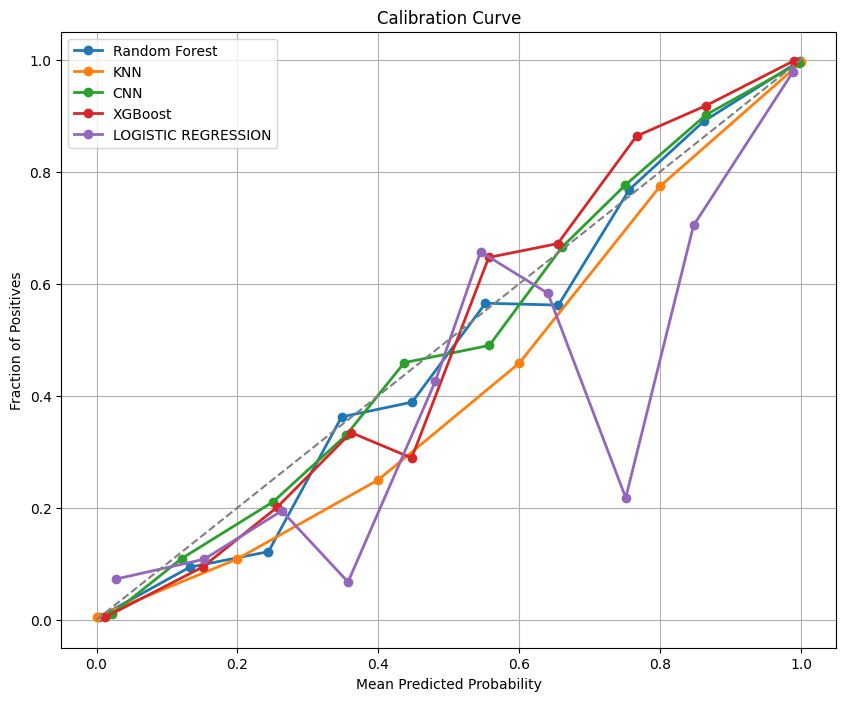

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

def plot_calibration_curve(y_true, y_prob_dict, n_bins=10):
    plt.figure(figsize=(10, 8))
    
    for name, y_prob in y_prob_dict.items():
        prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)
        plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label=name)
    
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Curve')
    plt.legend()
    plt.grid(True)
    plt.show()


predicciones = {
    'Random Forest': RF_y_pred_prob,
    'KNN': KNN_y_pred_prob,
    'CNN': y_pred_prob3 ,
    'XGBoost': xgb_y_predict_prob  ,
    'LOGISTIC REGRESSION':  logistic_y_predict_prob ,
}

print(len(y_test))
for name, y_prob in predicciones.items():
    print(f"{name}: {len(y_prob)}")




plot_calibration_curve(y_test, predicciones)


Model Random Forest:

Class      Precision  Recall     F1-score  
0          0.99       1.00       0.99      
1          1.00       0.99       0.99      

Model KNN:

Class      Precision  Recall     F1-score  
0          0.99       0.99       0.99      
1          0.99       0.99       0.99      

Model CNN:

Class      Precision  Recall     F1-score  
0          0.97       0.98       0.98      
1          0.98       0.97       0.98      

Model XGBoost:

Class      Precision  Recall     F1-score  
0          0.98       0.99       0.99      
1          0.99       0.98       0.99      

Model LOGISTIC REGRESSION:

Class      Precision  Recall     F1-score  
0          0.72       0.87       0.79      
1          0.84       0.67       0.74      

      Metric Random Forest     KNN     CNN XGBoost LOGISTIC REGRESSION
0   Accuracy        99.48%  98.86%  97.70%  98.65%              76.92%
1   F1-score        99.48%  98.86%  97.70%  98.65%              76.68%
2     Recall        99.48%  98.

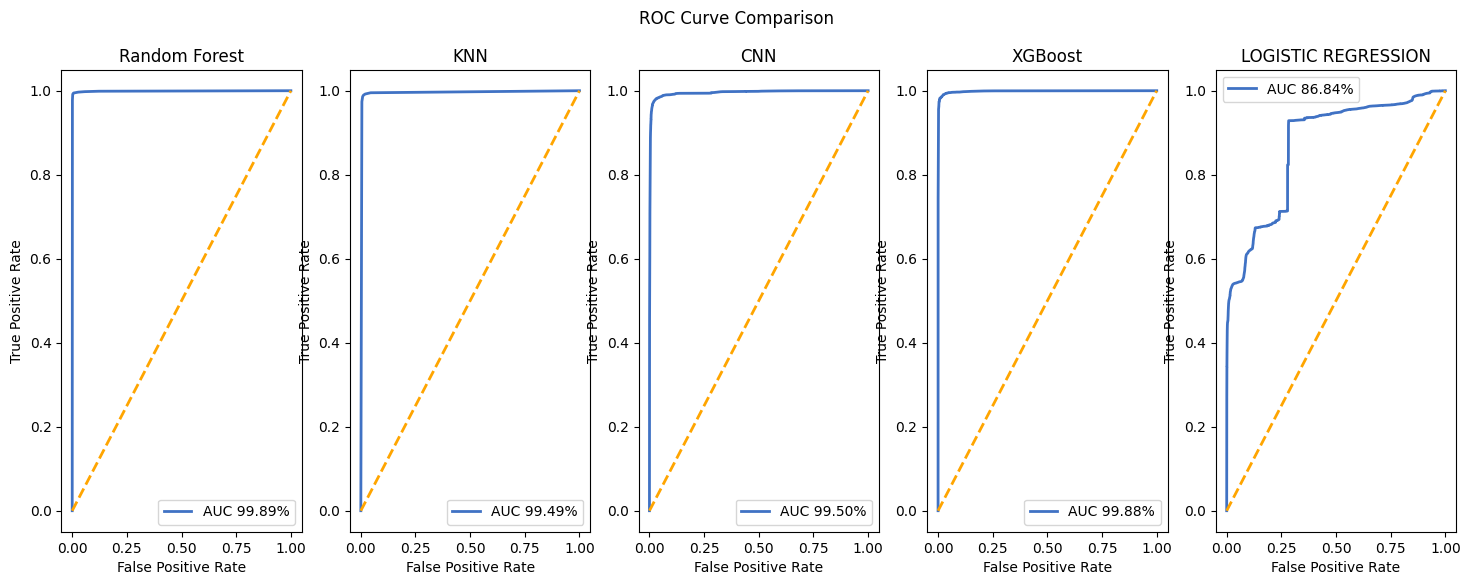

In [208]:
comparador(y_test, predicciones, 'RandomFores-KNN')




## **Analysis of Results**

### **Calibration Curve**

#### We observe that Random Forest is better calibrated across almost the entire spectrum of probabilities.

### **Evaluation Metrics**

#### The metrics are excellent for all models, although Random Forest and xgboost model perform better than other models.

### **Result**


#### Given the results, the most optimal model is **Random Forest and the xgboost**.





In [ ]:
import pickle



with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(Random_Forest, file)
    


